### Importar librerías

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Lectura de datos

In [2]:
train = pd.read_csv("train.csv", sep = ",") # Definimos na_values para identificar bien los valores perdidos
test = pd.read_csv("test.csv", sep = ",") # Definimos na_values para identificar bien los valores perdidos

# Dividir en características (X) y objetivo (y)
X_train = train.drop(columns=['price', 'id'])
Y_train = train['price']

# Mantener la columna 'id' para el test
train_ids = train['id']
test_ids = test['id']
X_test = test.copy()
X_test = X_test.drop(columns=['id'])

# Imprimir información general sobre los datos
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
dtypes: int64(2), object(9)
memory usage: 15.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         125690 non-null  object
 1   model         125690 non-null

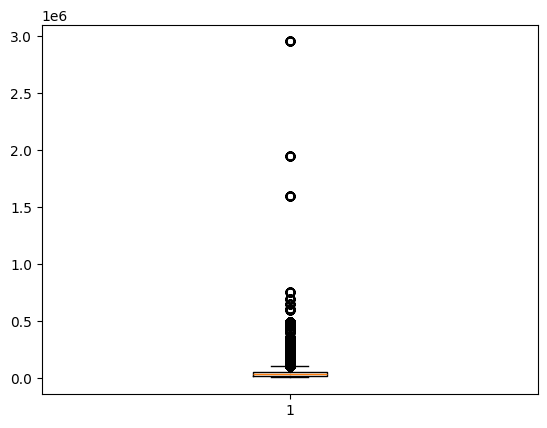

In [3]:
plt.boxplot(train['price'])
plt.show()

In [4]:
train['price'].describe()

count    1.885330e+05
mean     4.387802e+04
std      7.881952e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.082500e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64

### Preprocesamiento

In [5]:
#Identificamos valores vacios
print(X_test.isnull().sum())

brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64


In [6]:
# Identificar columnas categóricas
categorical_columns = list(X_train.select_dtypes(exclude=np.number).columns)
numerical_columns = list(X_train.select_dtypes(include=np.number).columns)

for col in numerical_columns:
    if X_train[col].isnull().sum() > 0:
        X_train.fillna({col: X_train[col].median()}, inplace=True)
    if X_test[col].isnull().sum() > 0:
        X_test.fillna({col: X_test[col].median()}, inplace=True)

for col in categorical_columns:
    if X_train[col].isnull().sum() > 0:
        X_train.fillna({col: 'unknown'}, inplace=True)
    if X_test[col].isnull().sum() > 0:
        X_test.fillna({col: 'unknown'}, inplace=True)

for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

for col in numerical_columns:
    X_train[col] = X_train[col].astype('int64')
    X_test[col] = X_test[col].astype('int64')

Y_train = Y_train.astype('float64')

print(X_train.isnull().sum())
print(X_test.isnull().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64


In [7]:
categorical_columns, numerical_columns

(['brand',
  'model',
  'fuel_type',
  'engine',
  'transmission',
  'ext_col',
  'int_col',
  'accident',
  'clean_title'],
 ['model_year', 'milage'])

### División en entrenamiento y validacion

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

### CatBoost

In [31]:
# CatBoost
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, random_seed=42, verbose=1)
cat_model.fit(X_train, Y_train, cat_features=categorical_columns, eval_set=(X_val, Y_val))

0:	learn: 79038.4373416	test: 73693.6290447	best: 73693.6290447 (0)	total: 206ms	remaining: 1m 43s
1:	learn: 78353.8225783	test: 72941.4117050	best: 72941.4117050 (1)	total: 305ms	remaining: 1m 16s
2:	learn: 77763.6787834	test: 72287.7292355	best: 72287.7292355 (2)	total: 381ms	remaining: 1m 3s
3:	learn: 77267.7185110	test: 71759.1701946	best: 71759.1701946 (3)	total: 449ms	remaining: 55.7s
4:	learn: 76806.7583578	test: 71262.9883803	best: 71262.9883803 (4)	total: 531ms	remaining: 52.6s
5:	learn: 76412.9146834	test: 70835.1463000	best: 70835.1463000 (5)	total: 609ms	remaining: 50.1s
6:	learn: 76088.5021884	test: 70483.9203885	best: 70483.9203885 (6)	total: 686ms	remaining: 48.3s
7:	learn: 75818.5575798	test: 70194.8246442	best: 70194.8246442 (7)	total: 771ms	remaining: 47.4s
8:	learn: 75598.7690447	test: 69950.8600968	best: 69950.8600968 (8)	total: 842ms	remaining: 45.9s
9:	learn: 75399.4742629	test: 69720.8757151	best: 69720.8757151 (9)	total: 926ms	remaining: 45.4s
10:	learn: 75241.3

### LightGBM

In [15]:
# LightGBM
lgb_model = LGBMRegressor(
boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.05,
    n_estimators=200,
    objective='regression',
    force_row_wise=True,
    max_bin=10000,
    n_jobs=-1,
    verbose=1
)
lgb_model.fit(
    X_train, Y_train, 
    eval_set=[(X_train, Y_train), (X_val, Y_val)], 
    eval_metric='rmse',
    categorical_feature=categorical_columns,
)

[LightGBM] [Info] Total Bins 7257
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 11
[LightGBM] [Info] Start training from score 43890.785316


c:\Users\aleja\anaconda3\envs\IN\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(force_row_wise=True, learning_rate=0.05, max_bin=10000,
              n_estimators=200, n_jobs=-1, objective='regression', verbose=1)

In [17]:
lgb_predictions_train = lgb_model.predict(X_train)
lgb_predictions_test = lgb_model.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(Y_train, lgb_predictions_train))
print(f"RMSE Train: {rmse_train}")
submission = pd.DataFrame({
    'id': test_ids, 
    'price': lgb_predictions_test
    })
submission.to_csv('submission_lgb2.csv', index=False)

RMSE Train: 63738.24531973119


### RandomForestRegressor

In [21]:
X_test_encoded = X_test.copy()
for col in categorical_columns:
    X_test_encoded[col] = LabelEncoder().fit_transform(X_test_encoded[col])

In [22]:
# Crear un diccionario para almacenar los LabelEncoders para cada columna categórica
label_encoders = {}

# Copiar X_train y X_val para no modificar los originales
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()

# Aplicar LabelEncoder a cada columna categórica
for col in categorical_columns:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col])

    # Imputar valores no vistos en el conjunto de validación con 'unknown'
    X_val_encoded[col] = X_val_encoded[col].map(lambda s: 'unknown' if s not in le.classes_ else s)
    # Añadir 'unknown' a las clases del LabelEncoder
    le.classes_ = np.append(le.classes_, 'unknown')

    X_val_encoded[col] = le.transform(X_val_encoded[col])
    label_encoders[col] = le

    print("Categorías:", le.classes_)
    print("Transformación:", dict(zip(le.classes_, range(len(le.classes_)))))

    # Resultado del encoding
    print("Datos codificados:", le)

Categorías: ['Acura' 'Alfa' 'Aston' 'Audi' 'BMW' 'Bentley' 'Bugatti' 'Buick'
 'Cadillac' 'Chevrolet' 'Chrysler' 'Dodge' 'FIAT' 'Ferrari' 'Ford' 'GMC'
 'Genesis' 'Honda' 'Hummer' 'Hyundai' 'INFINITI' 'Jaguar' 'Jeep' 'Karma'
 'Kia' 'Lamborghini' 'Land' 'Lexus' 'Lincoln' 'Lotus' 'Lucid' 'MINI'
 'Maserati' 'Maybach' 'Mazda' 'McLaren' 'Mercedes-Benz' 'Mercury'
 'Mitsubishi' 'Nissan' 'Plymouth' 'Polestar' 'Pontiac' 'Porsche' 'RAM'
 'Rivian' 'Rolls-Royce' 'Saab' 'Saturn' 'Scion' 'Subaru' 'Suzuki' 'Tesla'
 'Toyota' 'Volkswagen' 'Volvo' 'smart' 'unknown']
Transformación: {'Acura': 0, 'Alfa': 1, 'Aston': 2, 'Audi': 3, 'BMW': 4, 'Bentley': 5, 'Bugatti': 6, 'Buick': 7, 'Cadillac': 8, 'Chevrolet': 9, 'Chrysler': 10, 'Dodge': 11, 'FIAT': 12, 'Ferrari': 13, 'Ford': 14, 'GMC': 15, 'Genesis': 16, 'Honda': 17, 'Hummer': 18, 'Hyundai': 19, 'INFINITI': 20, 'Jaguar': 21, 'Jeep': 22, 'Karma': 23, 'Kia': 24, 'Lamborghini': 25, 'Land': 26, 'Lexus': 27, 'Lincoln': 28, 'Lotus': 29, 'Lucid': 30, 'MINI': 31, 'Mas

In [23]:
# Crear y entrenar el modelo RandomForestRegressor
rf_model = RandomForestRegressor(
    max_depth=6, 
    min_samples_split=10, 
    min_samples_leaf=5, 
    n_jobs=-1, 
    n_estimators=200, 
    random_state=42,
    verbose=1
)
rf_model.fit(X_train_encoded, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished


RandomForestRegressor(max_depth=6, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

In [25]:
rf_predictions_train = rf_model.predict(X_train_encoded)
rf_predictions_test = rf_model.predict(X_test_encoded)
rmse_train = np.sqrt(mean_squared_error(Y_train, rf_predictions_train))
print(f"RMSE Train: {rmse_train}")
submission = pd.DataFrame({
    'id': test_ids, 
    'price': rf_predictions_test
    })
submission.to_csv('submission_rf2.csv', index=False)

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.0s
[Parallel(n_jobs=28)]: Done 200 out of 200 | elapsed:    0.0s finished


RMSE Train: 73295.13445928023


### XGBoost

In [42]:
dtrain = xgb.DMatrix(X_train, label=Y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=Y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test, enable_categorical=True)

params = {
    'objective': 'reg:squarederror',  # Tarea de regresión
    'device': 'cuda',                # Uso de GPU
    'max_depth': 8,                  # Profundidad máxima
    'eta': 0.05,                     # Tasa de aprendizaje reducida
    'subsample': 0.9,                # Mayor submuestreo de datos
    'colsample_bytree': 0.9,         # Mayor submuestreo de características
    'lambda': 2.0,                   # Regularización L2 más fuerte
    'alpha': 1.0                    # Regularización L1 adicional
}

num_boost_round = 300                # Más iteraciones
early_stopping_rounds = 20           # Detención temprana para evitar sobreajuste

evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=num_boost_round, 
    evals=evals, 
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=True
)

[0]	train-rmse:78829.61923	eval-rmse:74067.90860
[1]	train-rmse:77713.01251	eval-rmse:73489.97497
[2]	train-rmse:76880.96112	eval-rmse:73109.46666
[3]	train-rmse:75936.05047	eval-rmse:72657.38179
[4]	train-rmse:74992.22827	eval-rmse:72196.08595
[5]	train-rmse:74028.95697	eval-rmse:71787.84105
[6]	train-rmse:73219.15027	eval-rmse:71497.69625
[7]	train-rmse:72437.50136	eval-rmse:71200.41654
[8]	train-rmse:71739.46914	eval-rmse:70960.61922
[9]	train-rmse:71171.24116	eval-rmse:70785.24289
[10]	train-rmse:70610.34820	eval-rmse:70581.85039
[11]	train-rmse:69822.83054	eval-rmse:70348.75692
[12]	train-rmse:69019.50634	eval-rmse:70125.32861
[13]	train-rmse:68426.66986	eval-rmse:69899.22324
[14]	train-rmse:67754.50803	eval-rmse:69726.07884
[15]	train-rmse:67234.34399	eval-rmse:69613.29634
[16]	train-rmse:66630.56067	eval-rmse:69481.36375
[17]	train-rmse:66127.04000	eval-rmse:69366.93180
[18]	train-rmse:65484.20057	eval-rmse:69283.74420
[19]	train-rmse:65028.96988	eval-rmse:69200.79760
[20]	train

In [43]:
xgb_predictions_test = model.predict(dtest)
xgb_predictions_train = model.predict(dtrain)
rmse_train = np.sqrt(mean_squared_error(Y_train, xgb_predictions_train))
print(f"RMSE Train: {rmse_train}")
submission = pd.DataFrame({
    'id': test_ids, 
    'price': xgb_predictions_test
    })
submission.to_csv('submission_xgb2.csv', index=False)

RMSE Train: 54838.492487692405


### Red Neuronal

In [26]:
# Escalar variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [27]:
# Red Neuronal
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
nn_model.compile(optimizer='adam', loss='mean_squared_error')
nn_model.fit(X_train_scaled, Y_train, epochs=50, batch_size=20, validation_data=(X_val_scaled, Y_val), verbose=1)

Epoch 1/50


c:\Users\aleja\anaconda3\envs\IN\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7542/7542 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 6866328576.0000 - val_loss: 4829551616.0000
Epoch 2/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 5578971136.0000 - val_loss: 4826072064.0000
Epoch 3/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 6037646336.0000 - val_loss: 4811633664.0000
Epoch 4/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 6342282240.0000 - val_loss: 4827465216.0000
Epoch 5/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 5559197696.0000 - val_loss: 4807776256.0000
Epoch 6/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 5622685696.0000 - val_loss: 4816331264.0000
Epoch 7/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 6099073024.0000 - val_loss: 4819894784.0000
Epoch 8/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 5617654784.0000 - val_loss: 4809827328.0000
Epoch 9/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 5758163456.0000 - val_loss: 4799204352.0000
Epoch 10/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms

In [29]:
nn_predictions_train = nn_model.predict(X_train_scaled)
nn_predictions_test = nn_model.predict(X_test_scaled).flatten()
rmse_train = np.sqrt(mean_squared_error(Y_train, nn_predictions_train))
print(f"RMSE Train: {rmse_train}")
submission = pd.DataFrame({
    'id': test_ids, 
    'price': nn_predictions_test
    })
submission.to_csv('submission_nn2.csv', index=False)

4714/4714 ━━━━━━━━━━━━━━━━━━━━ 3s 560us/step
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 2s 560us/step
RMSE Train: 74527.41354294136


### Evaluar modelos
Predicciones del test

In [44]:
# Hacer predicciones en el conjunto de prueba
cat_predictions_test = cat_model.predict(X_test)
lgb_predictions_test = lgb_model.predict(X_test)
rf_predictions_test = rf_model.predict(X_test_encoded)
xgb_predictions_test = model.predict(dtest)
nn_predictions_test = nn_model.predict(X_test_scaled).flatten()

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.0s
[Parallel(n_jobs=28)]: Done 200 out of 200 | elapsed:    0.0s finished


3928/3928 ━━━━━━━━━━━━━━━━━━━━ 2s 600us/step


In [45]:
cat_predictions_train = cat_model.predict(X_train)
lgb_predictions_train = lgb_model.predict(X_train)
rf_predictions_train = rf_model.predict(X_train_encoded)
xgb_predictions_train = model.predict(dtrain)
nn_predictions_train = nn_model.predict(X_train_scaled).flatten()

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.0s
[Parallel(n_jobs=28)]: Done 200 out of 200 | elapsed:    0.1s finished


4714/4714 ━━━━━━━━━━━━━━━━━━━━ 3s 572us/step


Predicciones sobre el entrenamiento

### Ensamblar modelos

In [46]:
# Definir los pesos para cada modelo
weights = {
    'catboost': 0.2,
    'lightgbm': 0.2,
    'randomforest': 0.2,
    'xgboost': 0.2,
    'nn': 0.2
}

final_predictions_test = (
    weights['catboost'] * cat_predictions_test +
    weights['lightgbm'] * lgb_predictions_test +
    weights['randomforest'] * rf_predictions_test +
    weights['xgboost'] * xgb_predictions_test +
    weights['nn'] * nn_predictions_test
)

# Crear un DataFrame con las predicciones finales
submission = pd.DataFrame({
    'id': test_ids,
    'price': final_predictions_test
})

# Guardar las predicciones en un archivo CSV
submission.to_csv('submission_all_xgboost2.csv', index=False)

final_predictions_train = (
    weights['catboost'] * cat_predictions_train +
    weights['lightgbm'] * lgb_predictions_train +
    weights['randomforest'] * rf_predictions_train +
    weights['xgboost'] * xgb_predictions_train +
    weights['nn'] * nn_predictions_train
)

# Calcular el error cuadrático medio en el conjunto de entrenamiento
rmse_train = np.sqrt(mean_squared_error(Y_train, final_predictions_train))
print(f'RMSE en el conjunto de entrenamiento: {rmse_train}')

RMSE en el conjunto de entrenamiento: 66742.04726190204
